In [2]:
import timeit
import matplotlib.pyplot as plt
import pickle
from mnist import MNIST
from time import time
import numpy as np

In [3]:
from mnist import MNIST    # pip install python-mnist
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)
print("Done.")

Loading dataset....
Done.


In [4]:
def one_hot_encode(y):
    ot=np.zeros((y.size,y.max()+1),dtype=np.float32)
    ot[np.arange(y.size),y]=1
    return ot

In [5]:
y_train=one_hot_encode(y_train)
y_test=one_hot_encode(y_test)

# Import network, layers and functions

In [6]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,globalAveragePool,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 145


# Make Sequential Model

In [7]:
model=Sequential()
model.add(conv2d(input_shape=(28,28,1),num_kernels=16,kernel_size=3,activation=functions.relu))
model.add(max_pool())
model.add(dropout(0.2))
model.add(conv2d(num_kernels=32,kernel_size=3,activation=functions.relu))
model.add(max_pool())
model.add(dropout(0.3))
model.add(conv2d(num_kernels=64,kernel_size=3,activation=functions.relu))
# model.add(globalAveragePool())
model.add(flatten())
model.add(dense(256,activation=functions.relu))
# model.add(dropout(0.4))
model.add(dense(10,activation=functions.softmax))

# View Model Summary

In [8]:
model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- input_layer(InputLayer) (None, 28, 28, 1)          echo             0
__________________________________________________________________________________________
0 conv2d(conv2d)          (None, 28, 28, 16)         relu             160
__________________________________________________________________________________________
1 max_pool(max_pool)      (None, 14, 14, 16)         echo             0
__________________________________________________________________________________________
2 dropout(dropout)        (None, 14, 14, 16)         echo             0
__________________________________________________________________________________________
3 conv2d(conv2d)          (None, 14, 14, 32)         relu             4640
__________________________________________________________________________________________
4 max_pool(

# Compile model with optimizer, loss and lr

In [9]:
model.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.001)

# Train model

In [10]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

In [ ]:
model.fit(X_train,y_train,batch_size=128,epochs=5,validation_data=(X_test,y_test))

EPOCH: 1 / 5
Progress:  50176 / 60000  - 11s - 0.14s/sample - loss: 0.5990 - accuracy: 0.8476      __

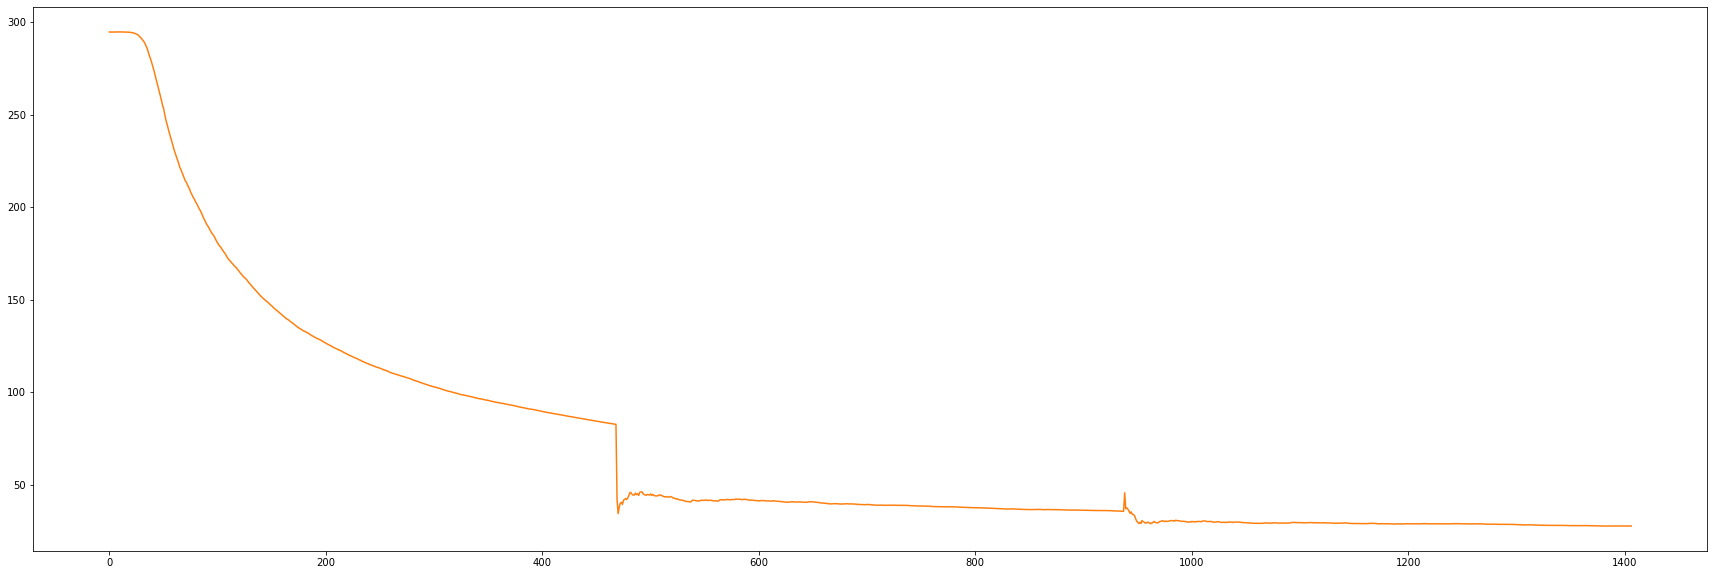

In [15]:
plt.figure(figsize=(30,10))
plt.plot(losses,color='#ff7f0e')
plt.show()

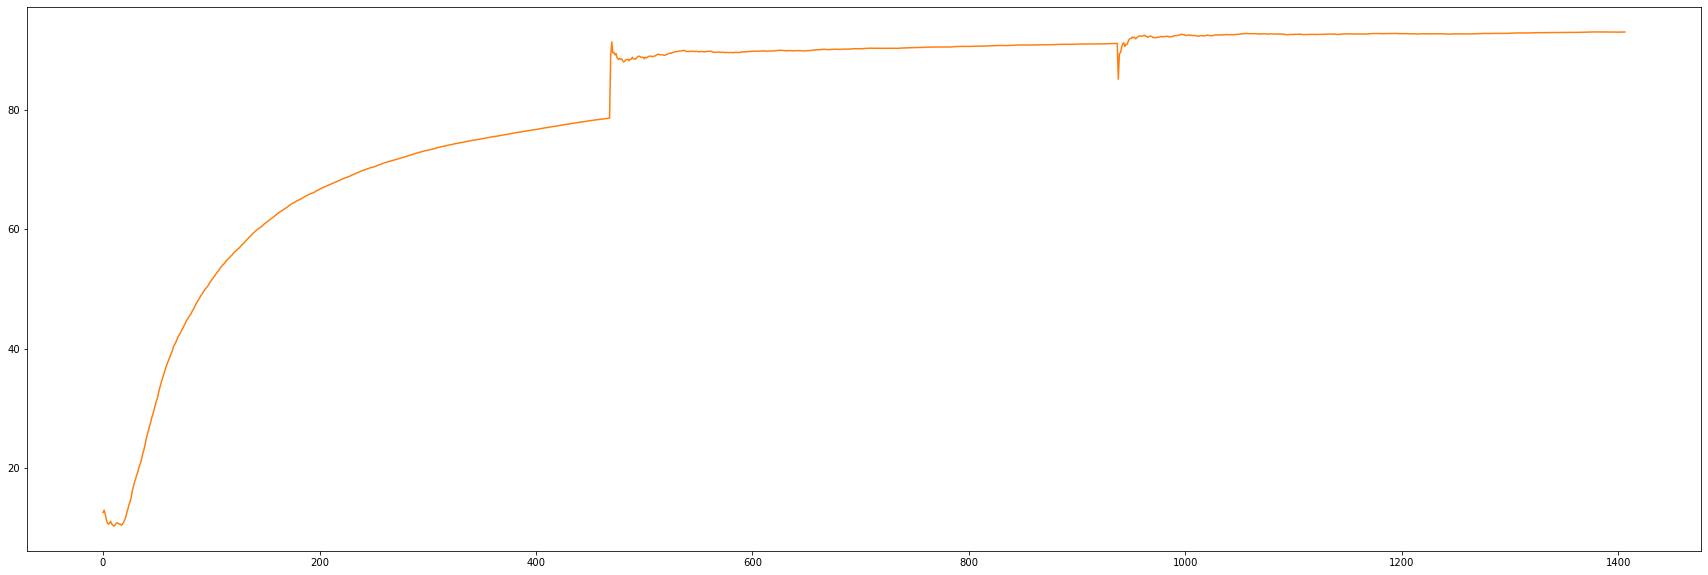

In [16]:
plt.figure(figsize=(30,10))
plt.plot(train_acc,color='#ff7f0e')
plt.show()

Prediction: [7] 
Correct:    [7]


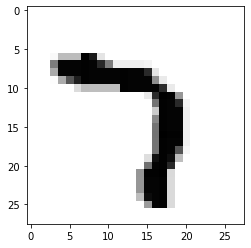

In [88]:
ck=np.random.randint(0,60000-100)
inp,y_inp=X_train[ck:ck+1],y_train[ck:ck+1]
logits=model.predict(inp)
ans=logits.argmax(axis=1)
cor=y_inp.argmax(axis=1)
print("Prediction:",ans,"\nCorrect:   ",cor)
plt.imshow(inp[0].reshape(28,28), cmap='Greys')

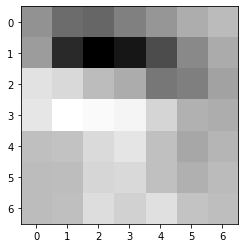

In [89]:
plt.imshow(np.dot(model.sequence[6].a_out,model.sequence[8].weights[:,ans[0]]).sum(axis=3).squeeze(),cmap='Greys')

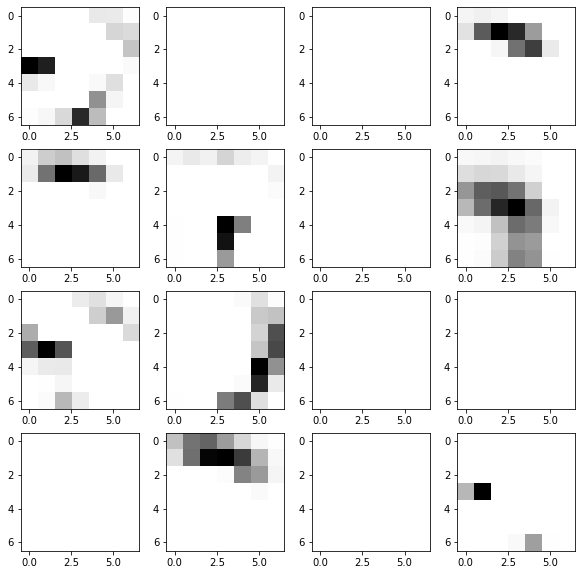

In [90]:
fig, ax = plt.subplots(nrows=4,ncols=4,figsize=[10,10])
fig.patch.set_facecolor('white')
pme=model.sequence[6].z_out.transpose(3,0,1,2)
for i,axi in enumerate(ax.flat):
    axi.imshow(pme[i].reshape(pme.shape[-2:]), cmap='Greys')